In [5]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [6]:
df = pd.read_csv('classification_data_all.csv')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

,prompt,task type
0,Produce animated content synced to this file.,ATV
1,I need a printed version of this narration.,STT
2,Provide a text output of this announcement photo.,ITT
3,Say the following status update.,TTS
4,"Tell me more about: I uploaded a file, now what?",UNK
...,...,...
595,Please read this aloud.,TTS
596,Convert this vocal recording into motion graph...,ATV
597,Tell me more about: Can you think like a person?,UNK
598,Make a text document from this conversation.,STT


In [7]:
possible_labels = df['task type'].unique().tolist()
print(f"Possible labels: {possible_labels}")

Possible labels: ['ATV', 'STT', 'ITT', 'TTS', 'UNK', 'VTT', 'TTI', 'ITA', 'TTV', 'ATI']


In [8]:
df['task type'].value_counts()

UNK    150
ATV     50
STT     50
ITT     50
TTS     50
VTT     50
TTI     50
ITA     50
TTV     50
ATI     50
Name: task type, dtype: int64

In [9]:
le = LabelEncoder()
df['task_type_encoded'] = le.fit_transform(df['task type'])
df = df.drop('task type', axis=1)
# To get the original string labels back from the encoded values:
original_labels = le.inverse_transform(df['task_type_encoded'])
joblib.dump(le, 'saved_models/label_encoder.joblib')

# print mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_mapping)
df

Label mapping: {'ATI': 0, 'ATV': 1, 'ITA': 2, 'ITT': 3, 'STT': 4, 'TTI': 5, 'TTS': 6, 'TTV': 7, 'UNK': 8, 'VTT': 9}


,prompt,task_type_encoded
0,Produce animated content synced to this file.,1
1,I need a printed version of this narration.,4
2,Provide a text output of this announcement photo.,3
3,Say the following status update.,6
4,"Tell me more about: I uploaded a file, now what?",8
...,...,...
595,Please read this aloud.,6
596,Convert this vocal recording into motion graph...,1
597,Tell me more about: Can you think like a person?,8
598,Make a text document from this conversation.,4


## Train models on TF-IDF embeddings

In [10]:
# Features and target
X = pd.DataFrame(df['prompt'])
y = pd.DataFrame(df['task_type_encoded'])

# Split the data, stratifying by the target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

In [11]:
X_train

,prompt
274,Turn this logline into a dynamic video scene.
397,Capture the headline from this newspaper image.
371,Draw and animate scenes for this recorded voice.
408,Turn the visual elements into sound.
411,Can you explain: Make this file useful.
...,...
438,Can you write out this chat recording?
394,Identify text from this business card image.
415,What’s shown in this painting? Say it aloud.
238,I need subtitles for this recording.


In [7]:
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit on training data and transform
X_train_tfidf = vectorizer.fit_transform(X_train['prompt'])
X_test_tfidf = vectorizer.transform(X_test['prompt'])
# Save the TF-IDF vectorizer for later use
joblib.dump(vectorizer, 'saved_models/tfidf_vectorizer.joblib')

['saved_models/tfidf_vectorizer.joblib']

In [8]:
X_train_tfidf

<540x563 sparse matrix of type '<class 'numpy.float64'>'
	with 3733 stored elements in Compressed Sparse Row format>

In [9]:
# Convert X_train_tfidf to DataFrame
X_train_df = pd.DataFrame(
    X_train_tfidf.toarray(), 
    columns=vectorizer.get_feature_names_out(), 
    index=X_train.index
)

# Convert X_test_tfidf to DataFrame
X_test_df = pd.DataFrame(
    X_test_tfidf.toarray(), 
    columns=vectorizer.get_feature_names_out(), 
    index=X_test.index
)

In [10]:
X_train_df

,2020,about,abstract,accessible,accompany,accurately,acoustic,adapt,advertisement,ai,...,won,word,words,would,write,writing,written,you,your,youtube
274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.295264,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.367763,0.0,0.0,0.261977,0.0,0.0
394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [8]:
def train_model(model, model_name, embedding_type, X_train, y_train, X_test, y_test, cmap='Purples'): # Blues
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-score: {f1:.3f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.inverse_transform(sorted(y_test['task_type_encoded'].unique()))))

    # Confusion matrix with original labels
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    cm = np.round(cm * 100, 2)
    labels = le.inverse_transform(sorted(y_test['task_type_encoded'].unique()))

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap=cmap)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name} ({embedding_type} Embeddings)')
    plt.savefig(f'graphs/CM_{model_name}_{embedding_type}.png')
    print(f"Confusion matrix saved as graphs/CM_{model_name}_{embedding_type}.png")
    plt.show()
    return model

### Train Logistic Regression

Accuracy: 0.617
Precision: 0.640
Recall: 0.617
F1-score: 0.611

Classification Report:
              precision    recall  f1-score   support

         ATI       0.50      0.40      0.44         5
         ATV       0.33      0.60      0.43         5
         ITA       0.75      0.60      0.67         5
         ITT       1.00      0.60      0.75         5
         STT       0.50      0.40      0.44         5
         TTI       0.33      0.20      0.25         5
         TTS       1.00      0.60      0.75         5
         TTV       0.50      0.60      0.55         5
         UNK       0.79      1.00      0.88        15
         VTT       0.40      0.40      0.40         5

    accuracy                           0.62        60
   macro avg       0.61      0.54      0.56        60
weighted avg       0.64      0.62      0.61        60

Confusion matrix saved as graphs/CM_Logistic Regression_TF-IDF.png


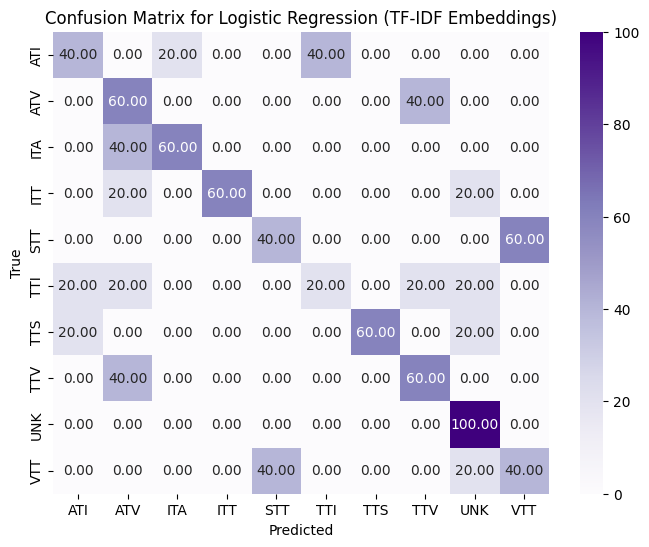

['saved_models/LogReg_Tf-Idf.joblib']

In [12]:
log_reg_tf_idf = LogisticRegression(max_iter=1000, random_state=42)
log_reg_tf_idf = train_model(log_reg_tf_idf, 'Logistic Regression', 'TF-IDF', X_train_df, y_train.values.ravel(), X_test_df, y_test)
joblib.dump(log_reg_tf_idf, 'saved_models/LogReg_Tf-Idf.joblib')

### Train Random Forest

Accuracy: 0.650
Precision: 0.659
Recall: 0.650
F1-score: 0.629

Classification Report:
              precision    recall  f1-score   support

         ATI       0.50      0.80      0.62         5
         ATV       0.60      0.60      0.60         5
         ITA       1.00      0.40      0.57         5
         ITT       0.67      0.40      0.50         5
         STT       0.60      0.60      0.60         5
         TTI       0.33      0.20      0.25         5
         TTS       0.60      0.60      0.60         5
         TTV       0.57      0.80      0.67         5
         UNK       0.79      1.00      0.88        15
         VTT       0.67      0.40      0.50         5

    accuracy                           0.65        60
   macro avg       0.63      0.58      0.58        60
weighted avg       0.66      0.65      0.63        60

Confusion matrix saved as graphs/CM_Random Forest_TF-IDF.png


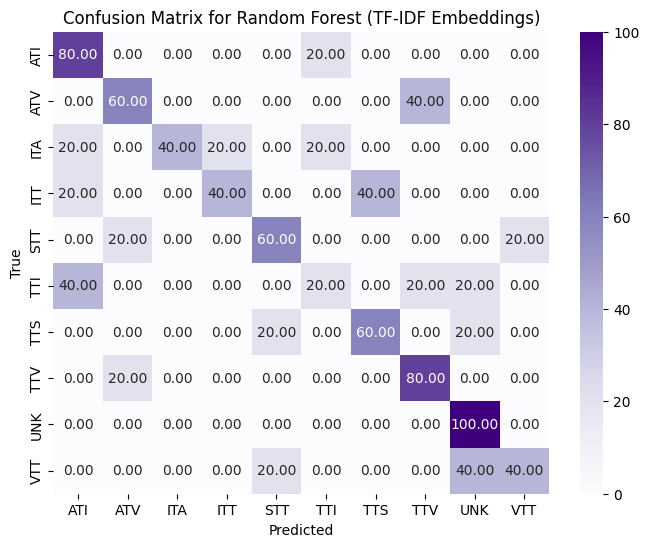

['saved_models/RanFor_Tf-Idf.joblib']

In [13]:
ran_for_tf_idf = RandomForestClassifier(random_state=42)
ran_for_tf_idf = train_model(ran_for_tf_idf, 'Random Forest', 'TF-IDF', X_train_df, y_train.values.ravel(), X_test_df, y_test)
joblib.dump(ran_for_tf_idf, 'saved_models/RanFor_Tf-Idf.joblib')

### Train SVM

Accuracy: 0.583
Precision: 0.605
Recall: 0.583
F1-score: 0.580

Classification Report:
              precision    recall  f1-score   support

         ATI       0.33      0.60      0.43         5
         ATV       0.29      0.40      0.33         5
         ITA       0.75      0.60      0.67         5
         ITT       1.00      0.60      0.75         5
         STT       0.33      0.40      0.36         5
         TTI       0.00      0.00      0.00         5
         TTS       1.00      0.60      0.75         5
         TTV       0.50      0.60      0.55         5
         UNK       0.94      1.00      0.97        15
         VTT       0.25      0.20      0.22         5

    accuracy                           0.58        60
   macro avg       0.54      0.50      0.50        60
weighted avg       0.61      0.58      0.58        60

Confusion matrix saved as graphs/CM_SVM_TF-IDF.png


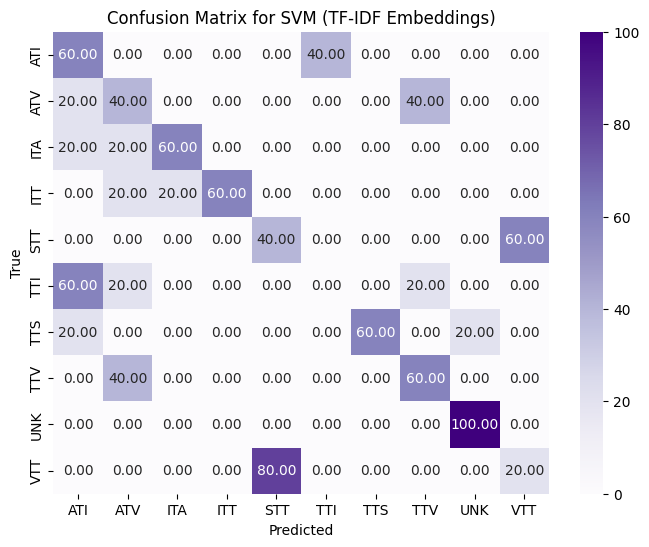

['saved_models/SVM_Tf-Idf.joblib']

In [14]:
svm_tf_idf = SVC(random_state=42)
svm_tf_idf = train_model(svm_tf_idf, 'SVM', 'TF-IDF', X_train_df, y_train.values.ravel(), X_test_df, y_test)
joblib.dump(svm_tf_idf, 'saved_models/SVM_Tf-Idf.joblib')

### Train KNN

Accuracy: 0.517
Precision: 0.524
Recall: 0.517
F1-score: 0.514

Classification Report:
              precision    recall  f1-score   support

         ATI       0.50      0.40      0.44         5
         ATV       0.17      0.20      0.18         5
         ITA       0.43      0.60      0.50         5
         ITT       0.67      0.40      0.50         5
         STT       0.40      0.40      0.40         5
         TTI       0.17      0.20      0.18         5
         TTS       0.33      0.20      0.25         5
         TTV       0.60      0.60      0.60         5
         UNK       0.88      0.93      0.90        15
         VTT       0.40      0.40      0.40         5

    accuracy                           0.52        60
   macro avg       0.45      0.43      0.44        60
weighted avg       0.52      0.52      0.51        60

Confusion matrix saved as graphs/CM_KNN_TF-IDF.png


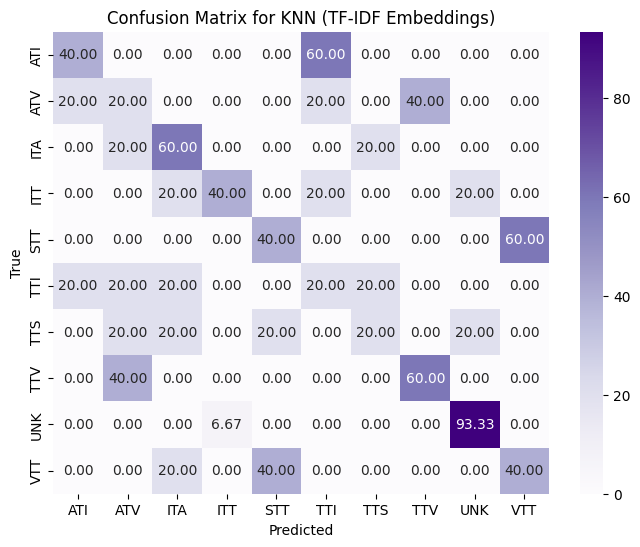

['saved_models/KNN_Tf-Idf.joblib']

In [15]:
knn_tf_idf = KNeighborsClassifier()
knn_tf_idf = train_model(knn_tf_idf, 'KNN', 'TF-IDF', X_train_df, y_train.values.ravel(), X_test_df, y_test)
joblib.dump(knn_tf_idf, 'saved_models/KNN_Tf-Idf.joblib')

### Train CatBoost

In [16]:
X_train_cb, X_val_cb, y_train_cb, y_val_cb = train_test_split(
    X_train_df, y_train, test_size=0.1, random_state=42, stratify=y_train
)

In [17]:
catboost_tf_idf = CatBoostClassifier(
    early_stopping_rounds=20,
    verbose=20,
    random_state=42
)

catboost_tf_idf.fit(
    X_train_cb, y_train_cb,
    eval_set=(X_val_cb, y_val_cb)
)

Learning rate set to 0.106429
0:	learn: 2.1924761	test: 2.1886080	best: 2.1886080 (0)	total: 68.1ms	remaining: 1m 8s
20:	learn: 1.6033788	test: 1.7466118	best: 1.7466118 (20)	total: 149ms	remaining: 6.94s
40:	learn: 1.4183139	test: 1.6196596	best: 1.6196596 (40)	total: 222ms	remaining: 5.18s
60:	learn: 1.2836077	test: 1.5428446	best: 1.5428446 (60)	total: 295ms	remaining: 4.55s
80:	learn: 1.1751595	test: 1.4846914	best: 1.4841193 (79)	total: 369ms	remaining: 4.19s
100:	learn: 1.0893420	test: 1.4466195	best: 1.4466195 (100)	total: 443ms	remaining: 3.94s
120:	learn: 1.0159181	test: 1.4157284	best: 1.4140528 (119)	total: 518ms	remaining: 3.76s
140:	learn: 0.9657616	test: 1.3832446	best: 1.3832015 (139)	total: 591ms	remaining: 3.6s
160:	learn: 0.9197846	test: 1.3568425	best: 1.3568425 (160)	total: 692ms	remaining: 3.61s
180:	learn: 0.8808902	test: 1.3536317	best: 1.3518852 (176)	total: 766ms	remaining: 3.47s
200:	learn: 0.8497195	test: 1.3465816	best: 1.3465816 (200)	total: 842ms	remaining

Accuracy: 0.617
Precision: 0.600
Recall: 0.617
F1-score: 0.582

Classification Report:
              precision    recall  f1-score   support

         ATI       0.43      0.60      0.50         5
         ATV       0.50      0.60      0.55         5
         ITA       0.50      0.40      0.44         5
         ITT       0.50      0.20      0.29         5
         STT       0.75      0.60      0.67         5
         TTI       0.00      0.00      0.00         5
         TTS       0.44      0.80      0.57         5
         TTV       0.57      0.80      0.67         5
         UNK       0.83      1.00      0.91        15
         VTT       1.00      0.40      0.57         5

    accuracy                           0.62        60
   macro avg       0.55      0.54      0.52        60
weighted avg       0.60      0.62      0.58        60

Confusion matrix saved as graphs/CM_CatBoost_TF-IDF.png


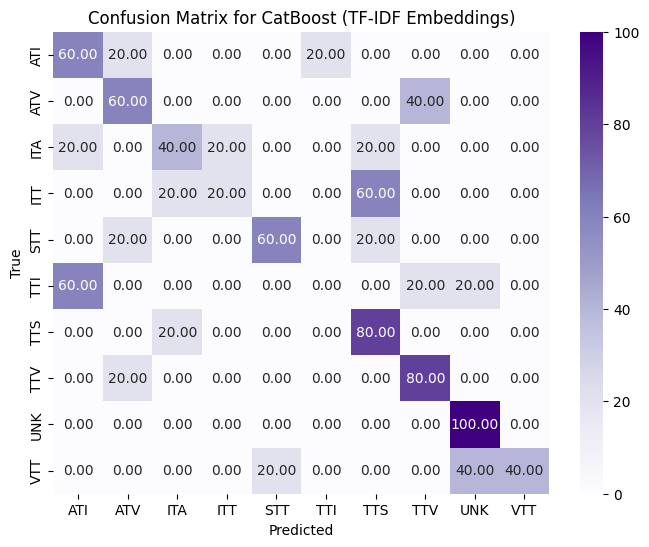

In [18]:
y_pred = catboost_tf_idf.predict(X_test_df)
model_name = 'CatBoost'
embedding_type = 'TF-IDF'
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.inverse_transform(sorted(y_test['task_type_encoded'].unique()))))

# Confusion matrix with original labels
cm = confusion_matrix(y_test, y_pred, normalize='true')
cm = np.round(cm * 100, 2)
labels = le.inverse_transform(sorted(y_test['task_type_encoded'].unique()))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for {model_name} ({embedding_type} Embeddings)')
plt.savefig(f'graphs/CM_{model_name}_{embedding_type}.png')
print(f"Confusion matrix saved as graphs/CM_{model_name}_{embedding_type}.png")
plt.show()

In [19]:
catboost_tf_idf.save_model("saved_models/CatBoost_Tf-Idf.cbm")

## Train models on BERT embeddings

In [20]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(texts, tokenizer, model, max_length=128):
    counter = 1
    model.eval()
    embeddings = []
    with torch.no_grad():
        for text in texts:
            counter += 1
            # if counter % 10 == 0:
            #     print(f"Processed {counter} texts")
            inputs = tokenizer(
                text, 
                return_tensors='pt', 
                truncation=True, 
                padding='max_length', 
                max_length=max_length
            )
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_embedding)
    return np.array(embeddings)

# Apply to each row in X_train and X_test
X_train_bert = get_bert_embeddings(X_train['prompt'].tolist(), tokenizer, bert_model)
X_test_bert = get_bert_embeddings(X_test['prompt'].tolist(), tokenizer, bert_model)

# Convert to DataFrames
X_train_bert_df = pd.DataFrame(X_train_bert, index=X_train.index)
X_test_bert_df = pd.DataFrame(X_test_bert, index=X_test.index)

In [21]:
X_train_bert_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
274,-0.293044,-0.358396,0.087509,-0.047965,-0.218742,-0.729716,-0.025841,0.600500,0.291949,-0.133172,...,0.570894,-0.180355,-0.145249,0.055735,-0.060862,0.475391,-0.276972,-0.517683,-0.243129,0.514876
397,-0.138579,0.015702,-0.383727,0.147672,-0.159003,-0.668860,0.071486,0.859048,0.249151,-0.449650,...,0.326643,-0.272322,-0.099749,-0.143195,-0.004549,0.353307,-0.192852,-0.450155,0.266695,0.530543
371,-0.446235,-0.079770,-0.567317,-0.166012,-0.374227,-0.464362,-0.034562,0.874903,0.555069,-0.372098,...,0.431609,-0.569409,0.108996,0.130216,-0.106645,0.498286,0.115109,-0.013070,-0.271695,0.410190
408,-0.106667,0.408910,-0.735872,-0.109500,-0.170226,-0.242138,0.064667,0.819449,0.391268,-0.904107,...,0.428760,-0.221676,0.012160,0.088313,0.043132,0.377845,0.075140,-0.379892,-0.243530,0.715878
411,-0.121034,-0.102566,-0.050658,0.031567,-0.100487,-0.521515,0.227763,0.467763,0.254516,-0.169096,...,-0.008311,-0.156309,-0.150843,0.064697,-0.145980,0.228550,-0.185442,-0.331981,-0.048226,0.628210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,-0.119742,-0.203556,0.001759,0.172543,0.063216,-0.234497,0.359874,0.453709,0.141101,-0.062528,...,0.088695,-0.243442,0.113339,-0.048336,-0.024592,-0.014213,-0.204782,-0.586161,0.131930,0.582083
394,-0.477318,-0.264120,-0.420037,-0.041176,-0.104148,-0.550083,-0.146789,0.716853,0.068780,-0.206163,...,0.595121,-0.225179,0.139177,-0.020449,-0.366545,0.348513,-0.511462,-0.277629,-0.104121,0.654562
415,0.159820,0.289926,-0.118651,-0.199204,-0.636525,-0.102874,0.647404,0.532328,0.183511,-0.689444,...,0.253043,-0.147163,0.034002,-0.048934,-0.253700,0.499169,-0.291665,-0.367424,0.052742,0.569742
238,-0.159515,0.028650,-0.132683,-0.081568,0.061574,-0.550401,0.301033,0.361131,0.197279,-0.463948,...,-0.139396,-0.497785,0.064936,-0.103422,-0.251911,0.298289,-0.099146,-0.204784,0.403536,0.548696


### Train Logistic Regression

Accuracy: 0.783
Precision: 0.809
Recall: 0.783
F1-score: 0.779

Classification Report:
              precision    recall  f1-score   support

         ATI       0.75      0.60      0.67         5
         ATV       0.50      0.60      0.55         5
         ITA       1.00      0.60      0.75         5
         ITT       1.00      0.60      0.75         5
         STT       0.67      0.40      0.50         5
         TTI       0.67      0.80      0.73         5
         TTS       0.83      1.00      0.91         5
         TTV       0.71      1.00      0.83         5
         UNK       1.00      1.00      1.00        15
         VTT       0.57      0.80      0.67         5

    accuracy                           0.78        60
   macro avg       0.77      0.74      0.73        60
weighted avg       0.81      0.78      0.78        60

Confusion matrix saved as graphs/CM_Logistic Regression_BERT.png


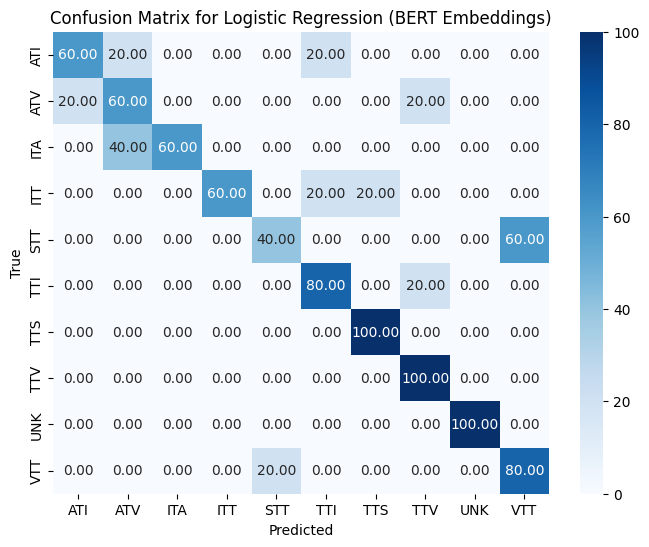

['saved_models/LogReg_Bert.joblib']

In [22]:
log_reg_bert = LogisticRegression(max_iter=1000, random_state=42)
log_reg_bert = train_model(log_reg_bert, 'Logistic Regression', 'BERT', X_train_bert_df, y_train.values.ravel(), X_test_bert_df, y_test, cmap='Blues')
joblib.dump(log_reg_bert, 'saved_models/LogReg_Bert.joblib')

### Train Random Forest

Accuracy: 0.600
Precision: 0.623
Recall: 0.600
F1-score: 0.584

Classification Report:
              precision    recall  f1-score   support

         ATI       0.67      0.40      0.50         5
         ATV       0.30      0.60      0.40         5
         ITA       0.67      0.40      0.50         5
         ITT       0.50      0.20      0.29         5
         STT       0.50      0.20      0.29         5
         TTI       0.44      0.80      0.57         5
         TTS       0.75      0.60      0.67         5
         TTV       0.50      0.60      0.55         5
         UNK       0.88      1.00      0.94        15
         VTT       0.50      0.40      0.44         5

    accuracy                           0.60        60
   macro avg       0.57      0.52      0.51        60
weighted avg       0.62      0.60      0.58        60

Confusion matrix saved as graphs/CM_Random Forest_BERT.png


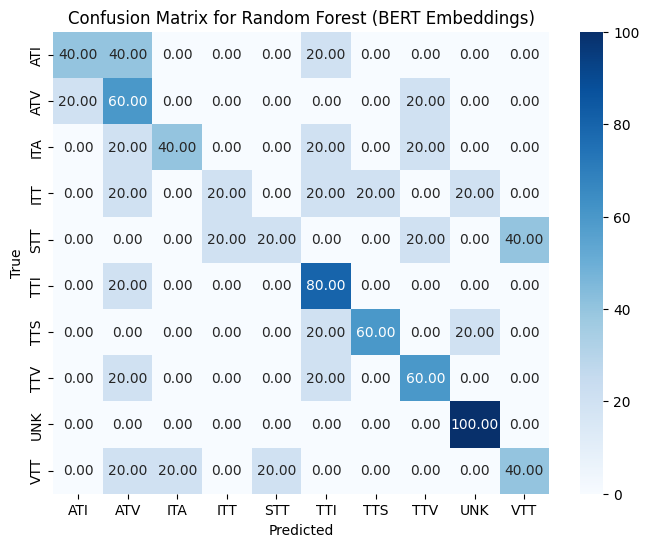

['saved_models/RanFor_Bert.joblib']

In [23]:
ran_for_bert = RandomForestClassifier(random_state=42)
ran_for_bert = train_model(ran_for_bert, 'Random Forest', 'BERT', X_train_bert_df, y_train.values.ravel(), X_test_bert_df, y_test, cmap='Blues')
joblib.dump(ran_for_bert, 'saved_models/RanFor_Bert.joblib')

### Train SVM

Accuracy: 0.600
Precision: 0.662
Recall: 0.600
F1-score: 0.588

Classification Report:
              precision    recall  f1-score   support

         ATI       1.00      0.40      0.57         5
         ATV       0.40      0.80      0.53         5
         ITA       0.40      0.40      0.40         5
         ITT       1.00      0.20      0.33         5
         STT       0.67      0.40      0.50         5
         TTI       0.43      0.60      0.50         5
         TTS       0.60      0.60      0.60         5
         TTV       0.60      0.60      0.60         5
         UNK       0.88      1.00      0.94        15
         VTT       0.20      0.20      0.20         5

    accuracy                           0.60        60
   macro avg       0.62      0.52      0.52        60
weighted avg       0.66      0.60      0.59        60

Confusion matrix saved as graphs/CM_SVM_BERT.png


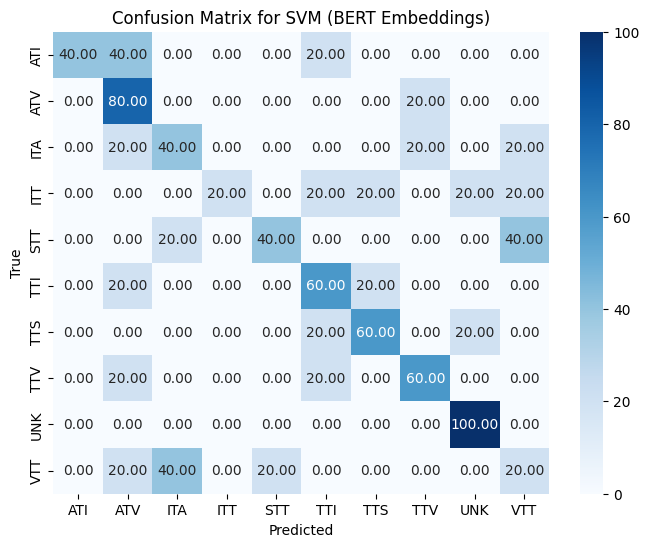

['saved_models/SVM_Bert.joblib']

In [24]:
svm_bert = SVC(random_state=42)
svm_bert = train_model(svm_bert, 'SVM', 'BERT', X_train_bert_df, y_train.values.ravel(), X_test_bert_df, y_test, cmap='Blues')
joblib.dump(svm_bert, 'saved_models/SVM_Bert.joblib')

### Train KNN

Accuracy: 0.583
Precision: 0.626
Recall: 0.583
F1-score: 0.584

Classification Report:
              precision    recall  f1-score   support

         ATI       0.38      0.60      0.46         5
         ATV       0.25      0.20      0.22         5
         ITA       0.40      0.40      0.40         5
         ITT       1.00      0.40      0.57         5
         STT       0.50      0.20      0.29         5
         TTI       0.25      0.40      0.31         5
         TTS       0.60      0.60      0.60         5
         TTV       0.80      0.80      0.80         5
         UNK       1.00      1.00      1.00        15
         VTT       0.33      0.40      0.36         5

    accuracy                           0.58        60
   macro avg       0.55      0.50      0.50        60
weighted avg       0.63      0.58      0.58        60

Confusion matrix saved as graphs/CM_KNN_BERT.png


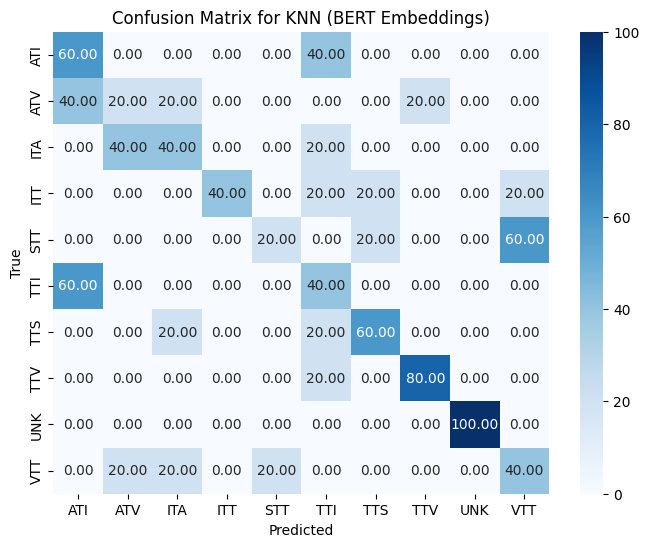

['saved_models/KNN_Bert.joblib']

In [25]:
knn_bert = KNeighborsClassifier()
knn_bert = train_model(knn_bert, 'KNN', 'BERT', X_train_bert_df, y_train.values.ravel(), X_test_bert_df, y_test, cmap='Blues')
joblib.dump(knn_bert, 'saved_models/KNN_Bert.joblib')

### Train CatBoost

In [26]:
X_train_bert_cb, X_val_bert_cb, y_train_bert_cb, y_val_bert_cb = train_test_split(
    X_train_bert_df, y_train, test_size=0.1, random_state=42, stratify=y_train
)

In [27]:
catboost_bert = CatBoostClassifier(
    early_stopping_rounds=20,
    verbose=20,
    random_state=42
)

catboost_bert.fit(
    X_train_bert_cb, y_train_bert_cb,
    eval_set=(X_val_bert_cb, y_val_bert_cb)
)

Learning rate set to 0.106429
0:	learn: 2.2515523	test: 2.2652659	best: 2.2652659 (0)	total: 133ms	remaining: 2m 13s
20:	learn: 1.4518703	test: 1.8108204	best: 1.8108204 (20)	total: 2.65s	remaining: 2m 3s
40:	learn: 1.0843797	test: 1.6758643	best: 1.6758643 (40)	total: 5.08s	remaining: 1m 58s
60:	learn: 0.8287960	test: 1.5930685	best: 1.5930321 (59)	total: 7.37s	remaining: 1m 53s
80:	learn: 0.6309550	test: 1.5056127	best: 1.5056127 (80)	total: 9.72s	remaining: 1m 50s
100:	learn: 0.4941177	test: 1.4469283	best: 1.4469283 (100)	total: 12.3s	remaining: 1m 49s
120:	learn: 0.4005811	test: 1.3857588	best: 1.3857588 (120)	total: 14.6s	remaining: 1m 46s
140:	learn: 0.3402939	test: 1.3388224	best: 1.3388224 (140)	total: 17.3s	remaining: 1m 45s
160:	learn: 0.2997659	test: 1.3149292	best: 1.3149292 (160)	total: 19.6s	remaining: 1m 42s
180:	learn: 0.2620696	test: 1.2893493	best: 1.2880225 (179)	total: 21.9s	remaining: 1m 39s
200:	learn: 0.2287964	test: 1.2712322	best: 1.2712322 (200)	total: 24.2s	

Accuracy: 0.667
Precision: 0.664
Recall: 0.667
F1-score: 0.646

Classification Report:
              precision    recall  f1-score   support

         ATI       0.75      0.60      0.67         5
         ATV       0.44      0.80      0.57         5
         ITA       0.60      0.60      0.60         5
         ITT       0.50      0.20      0.29         5
         STT       0.50      0.20      0.29         5
         TTI       0.57      0.80      0.67         5
         TTS       0.80      0.80      0.80         5
         TTV       0.75      0.60      0.67         5
         UNK       0.88      1.00      0.94        15
         VTT       0.40      0.40      0.40         5

    accuracy                           0.67        60
   macro avg       0.62      0.60      0.59        60
weighted avg       0.66      0.67      0.65        60

Confusion matrix saved as graphs/CM_CatBoost_BERT.png


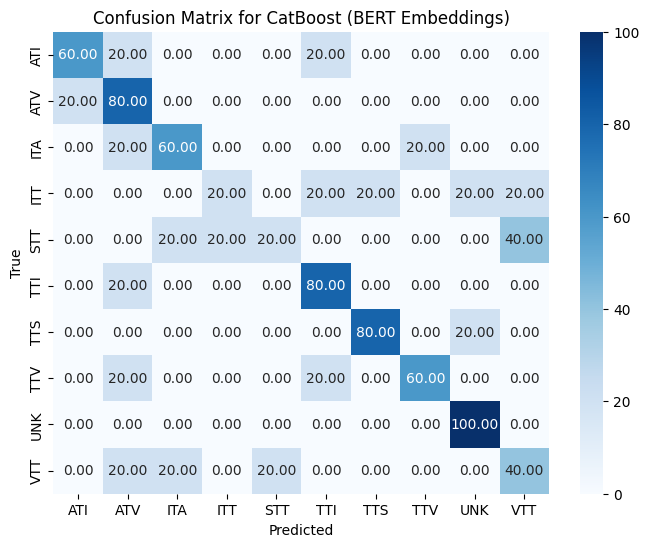

In [28]:
y_pred = catboost_bert.predict(X_test_bert_df)
model_name = 'CatBoost'
embedding_type = 'BERT'
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.inverse_transform(sorted(y_test['task_type_encoded'].unique()))))

# Confusion matrix with original labels
cm = confusion_matrix(y_test, y_pred, normalize='true')
cm = np.round(cm * 100, 2)
labels = le.inverse_transform(sorted(y_test['task_type_encoded'].unique()))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for {model_name} ({embedding_type} Embeddings)')
plt.savefig(f'graphs/CM_{model_name}_{embedding_type}.png')
print(f"Confusion matrix saved as graphs/CM_{model_name}_{embedding_type}.png")
plt.show()

In [29]:
catboost_bert.save_model("saved_models/CatBoost_Bert.cbm")

## Evaluate Interpreter Agent (gpt-3.5-turbo)

In [9]:
from constants import base_url, api_key, model as llm_name
from interpreter_agent import LLMInterpreter

Using model: gpt-3.5-turbo


In [10]:
interpreter_3 = LLMInterpreter()

In [11]:
X_test.head(5), y_test.head(5)

(                                                prompt
 418  Tell me more about: Do something interesting w...
 215          Generate visuals for this piece of audio.
 574            I need a transcript of this video file.
 419               What’s printed in this ticket photo?
 191       Sketch a scene inspired by this audio input.,
      task_type_encoded
 418                  8
 215                  1
 574                  9
 419                  3
 191                  0)

In [12]:
len(X_test)

60

In [15]:
X_test_llm_eval = X_test.copy()
X_test_llm_eval = X_test_llm_eval.reset_index(drop=True)
X_test_llm_eval['prediction_model_3'] = 'UNK'
X_test_llm_eval.head(5)

,prompt,prediction_model_3
0,Tell me more about: Do something interesting w...,UNK
1,Generate visuals for this piece of audio.,UNK
2,I need a transcript of this video file.,UNK
3,What’s printed in this ticket photo?,UNK
4,Sketch a scene inspired by this audio input.,UNK


In [ ]:
n_errors_model_3 = 0
indices_errors_model_3 = []
for i in range(len(X_test_llm_eval)):
    prompt = X_test_llm_eval['prompt'][i]
    try:
        prediction_3 = interpreter_3.get_task_type(prompt)
        if prediction_3 in possible_labels:
            X_test_llm_eval['prediction_model_3'][i] = prediction_3
        else:
            n_errors_model_3 += 1
            indices_errors_model_3.append(i)
    except:
        n_errors_model_3 += 1
        indices_errors_model_3.append(i)
print(f"Number of errors for model 3: {n_errors_model_3}")

In [23]:
X_test_llm_eval['prediction_model_3'] = le.transform(X_test_llm_eval['prediction_model_3'])
X_test_llm_eval.head(5)

,prompt,prediction_model_3
0,Tell me more about: Do something interesting w...,8
1,Generate visuals for this piece of audio.,0
2,I need a transcript of this video file.,9
3,What’s printed in this ticket photo?,3
4,Sketch a scene inspired by this audio input.,0


In [20]:
y_test.head(5)

,task_type_encoded
418,8
215,1
574,9
419,3
191,0


In [ ]:
y_pred = X_test_llm_eval['prediction_model_3']
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.inverse_transform(sorted(y_test['task_type_encoded'].unique()))))

# Confusion matrix with original labels
cm = confusion_matrix(y_test, y_pred, normalize='true')
cm = np.round(cm * 100, 2)
labels = le.inverse_transform(sorted(y_test['task_type_encoded'].unique()))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for Interpreter Agent (GPT-3.5-Turbo Model)')
plt.savefig(f'graphs/CM_Interpreter_Agent_GPT-3.5-Turbo.png')
plt.show()

### Evaluate Fine-Tuned LLM (BERT)

In [12]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [17]:
model_name = 'bert-base-uncased'
num_labels = 10

# Path to your saved model state dictionary
model_path = 'saved_models/best_model_bert_epoch_6.pt'
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print('Using device', device)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

Using device mps


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [18]:
X_test_texts = X_test['prompt'].tolist()
y_test_labels = y_test['task_type_encoded'].tolist()

num_labels = len(set(y_test_labels))
print(f"Number of labels: {num_labels}")

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

class PromptDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

test_dataset = PromptDataset(X_test_texts, y_test_labels, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=4)

Number of labels: 10


In [ ]:
model.eval() # Set model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad(): # Disable gradient calculations for evaluation
    eval_loop = tqdm(test_loader)
    for batch in eval_loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

100%|██████████| 15/15 [00:00<00:00, 16.55it/s]

Current accuracy: 0.917
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00         5
           3       1.00      0.80      0.89         5
           4       0.67      0.80      0.73         5
           5       1.00      1.00      1.00         5
           6       0.83      1.00      0.91         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00        15
           9       0.75      0.60      0.67         5

    accuracy                           0.92        60
   macro avg       0.91      0.90      0.90        60
weighted avg       0.92      0.92      0.92        60



Accuracy: 0.917
Precision: 0.924
Recall: 0.917
F1-score: 0.916

Classification Report:
              precision    recall  f1-score   support

         ATI       0.83      1.00      0.91         5
         ATV       1.00      0.80      0.89         5
         ITA       1.00      1.00      1.00         5
         ITT       1.00      0.80      0.89         5
         STT       0.67      0.80      0.73         5
         TTI       1.00      1.00      1.00         5
         TTS       0.83      1.00      0.91         5
         TTV       1.00      1.00      1.00         5
         UNK       1.00      1.00      1.00        15
         VTT       0.75      0.60      0.67         5

    accuracy                           0.92        60
   macro avg       0.91      0.90      0.90        60
weighted avg       0.92      0.92      0.92        60



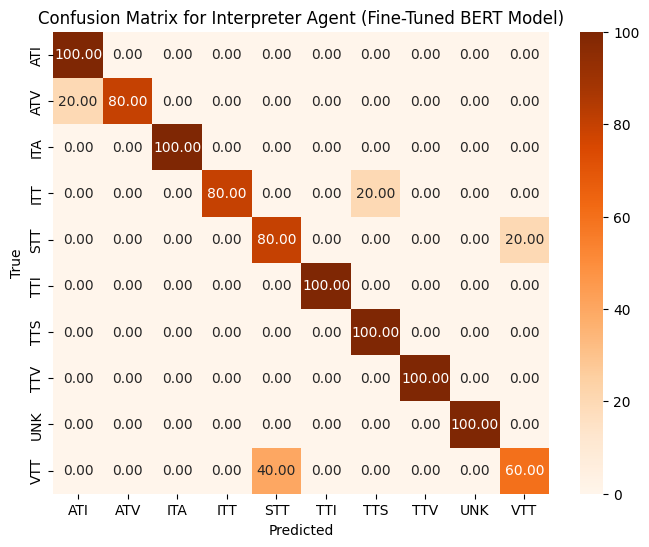

In [28]:
y_pred = all_preds
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.inverse_transform(sorted(y_test['task_type_encoded'].unique()))))

# Confusion matrix with original labels
cm = confusion_matrix(y_test, y_pred, normalize='true')
cm = np.round(cm * 100, 2)
labels = le.inverse_transform(sorted(y_test['task_type_encoded'].unique()))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Oranges') # OrRd
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for Interpreter Agent (Fine-Tuned BERT Model)')
plt.savefig(f'graphs/CM_Interpreter_Agent_BERT.png')
plt.show()